<a href="https://colab.research.google.com/github/GrE3lzzz/Gittea/blob/main/Classically_Punk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython import get_ipython
from IPython.display import display

import os
import tarfile
import urllib.request
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import joblib

In [ ]:
# URL of dataset
data_url = "https://storage.googleapis.com/qwasar-public/track-ds/classically_punk_music_genres.tar.gz"
data_path = "classically_punk_music_genres.tar.gz"
dataset_folder = "classically_punk_music_genres"

# Step 1: Download & Extract Dataset
if not os.path.exists(dataset_folder):
    print("Downloading dataset...")
    for attempt in range(3):
        try:
            urllib.request.urlretrieve(data_url, data_path)
            break
        except Exception as e:
            print(f"Download attempt {attempt + 1} failed: {e}")
            if attempt < 2:
                print("Retrying...")
            else:
                raise

    print("Extracting dataset...")
    os.makedirs(dataset_folder, exist_ok=True)
    with tarfile.open(data_path, "r:gz") as tar:
        tar.extractall(path=dataset_folder)
    print("Extraction completed.")

# Verify dataset extraction
if not os.path.exists(dataset_folder):
    raise ValueError(f"Dataset extraction failed, folder '{dataset_folder}' not found.")
print(f"Files in dataset folder: {os.listdir(dataset_folder)}")
if len(os.listdir(dataset_folder)) == 0:
    raise ValueError("Dataset extraction failed or folder is empty.")

Extracting dataset...
Extraction completed.
Files in dataset folder: ['genres']


In [ ]:
# Step 2: Feature Extraction Functions
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        features = {
            'mfcc_mean': np.mean(mfcc, axis=1),
            'tempo': tempo,
            'chroma_mean': np.mean(chroma, axis=1),
            'spectral_contrast_mean': np.mean(spectral_contrast, axis=1)
        }
        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        # Add more specific error handling or logging if necessary
        import traceback
        traceback.print_exc()
        return None

In [ ]:
# Step 3: Read Files & Extract Features
audio_files = []
labels = []
features_list = []

genres_path = os.path.join(dataset_folder, "genres")
if not os.path.exists(genres_path) or not os.path.isdir(genres_path):
    raise ValueError(f"Genres directory not found at: {genres_path}")

for genre in os.listdir(genres_path):
    genre_path = os.path.join(genres_path, genre)
    if os.path.isdir(genre_path):
        print(f"Processing genre: {genre}")
        # Modified file search to include recursive loop:
        for file in os.listdir(genre_path):
            file_path = os.path.join(genre_path, file)
            # Recursive loop to find audio files in all subfolders
            if os.path.isfile(file_path) and file_path.lower().endswith('.wav'):
                features = extract_features(file_path)
                if features is not None:
                    audio_files.append(features['mfcc_mean'])
                    labels.append(genre)
                    features_list.append(features)
            # Recursively loop through subfolders:
            elif os.path.isdir(file_path):
                for subfile in os.listdir(file_path):
                    subfile_path = os.path.join(file_path, subfile)
                    if os.path.isfile(subfile_path) and subfile_path.lower().endswith('.wav'):
                        features = extract_features(subfile_path)
                        if features is not None:
                            audio_files.append(features['mfcc_mean'])
                            labels.append(genre)
                            features_list.append(features)


# Convert to DataFrame
data = pd.DataFrame(features_list)
data['label'] = labels

# Check if the dataset is empty
if data.empty:
    raise ValueError("No valid audio files or features extracted. Check the dataset and feature extraction process.")

print("Dataset shape after feature extraction:", data.shape)

Processing genre: reggae
Processing genre: classical
Processing genre: metal
Processing genre: rock
Processing genre: disco
Processing genre: country
Processing genre: jazz
Processing genre: pop
Processing genre: hiphop
Processing genre: blues
Dataset shape after feature extraction: (1000, 5)


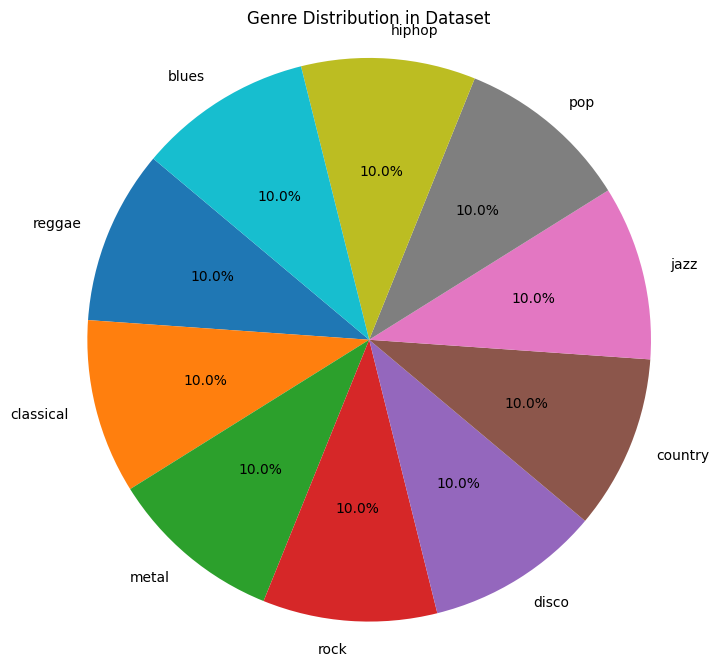

In [ ]:
# Plot Genre Distribution (Pie Chart)
def plot_genre_distribution(genre_distribution):
    """
    Plots a pie chart showing the distribution of genres in the dataset.
    """
    genres = list(genre_distribution.keys())
    counts = list(genre_distribution.values())

    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=genres, autopct='%1.1f%%', startangle=140)
    plt.title("Genre Distribution in Dataset")
    plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
    plt.show()

# Calculate genre distribution from the 'label' column in the DataFrame
genre_distribution = data['label'].value_counts().to_dict()

# Call the function to plot genre distribution
plot_genre_distribution(genre_distribution)

In [ ]:
# Step 4: Verify Column Names
print("Columns in dataset:", data.columns)

if 'mfcc_mean' not in data.columns:
    raise KeyError("Column 'mfcc_mean' is missing. Check your data loading or preprocessing steps.")

Columns in dataset: Index(['mfcc_mean', 'tempo', 'chroma_mean', 'spectral_contrast_mean', 'label'], dtype='object')


In [ ]:
# Step 5: Ensure Target Columns are Numeric
for col in ['tempo', 'chroma_mean', 'spectral_contrast_mean']:
    # Check if the column exists before converting
    if col in data.columns:
        # Convert to numeric, handling errors by filling with a default value
        # You might want to change the default value based on your data
        data[col] = pd.to_numeric(data[col], errors='coerce').fillna(0)
    else:
        print(f"Warning: Column '{col}' not found in the DataFrame.")

# Check for missing values in target columns (after filling)
print("Missing values in target columns (after filling):")
print(data[['tempo', 'chroma_mean', 'spectral_contrast_mean']].isnull().sum())

# You might not need to drop rows anymore as NaNs are filled
# data = data.dropna(subset=['tempo', 'chroma_mean', 'spectral_contrast_mean'])

# Check dataset shape
print("Dataset shape:", data.shape)

# Check if the dataset is empty
if data.empty:
    raise ValueError("Dataset is empty. Check your data preprocessing.")

Missing values in target columns (after filling):
tempo                     0
chroma_mean               0
spectral_contrast_mean    0
dtype: int64
Dataset shape: (1000, 5)


In [ ]:
# Step 6: Prepare Data for Machine Learning
# Encode Labels
label_encoder = LabelEncoder()
data['label_encoded'] = label_encoder.fit_transform(data['label'])

# Features and Targets
X = data.drop(columns=['label', 'label_encoded', 'tempo', 'chroma_mean', 'spectral_contrast_mean'])
y_classification = data['label_encoded']
y_regression = data[['tempo', 'chroma_mean', 'spectral_contrast_mean']]

In [ ]:
# Step 7: Verify Numeric Columns in y_regression
print("Columns in y_regression:", y_regression.columns)
print("Data types in y_regression:", y_regression.dtypes)

# Ensure all target columns are numeric
if not all(np.issubdtype(dtype, np.number) for dtype in y_regression.dtypes):
    raise ValueError("Target columns for regression must be numeric.")

Columns in y_regression: Index(['tempo', 'chroma_mean', 'spectral_contrast_mean'], dtype='object')
Data types in y_regression: tempo                     float64
chroma_mean               float64
spectral_contrast_mean    float64
dtype: object


In [ ]:
# Step 8: Perform Train-Test Split
print("Performing train-test split...")
X_train, X_test, y_train_clf, y_test_clf, y_train_reg, y_test_reg = train_test_split(
    X, y_classification, y_regression, test_size=0.2, random_state=42
)
print("X_train shape after splitting:", X_train.shape)

if X_train.empty:
    raise ValueError("X_train is empty. Check your train-test split parameters.")

Performing train-test split...
X_train shape after splitting: (800, 1)


In [ ]:
# Step 9: Access the Column
print("First few values of 'mfcc_mean':", X_train['mfcc_mean'].head())

First few values of 'mfcc_mean': 29     [-93.51898, 80.19957, -0.32109216, 15.24674, 4...
535    [-111.62214, 82.249146, 13.051351, 31.925335, ...
695    [-168.13132, 108.280045, -14.153984, 30.439228...
557    [-141.01443, 123.921104, -2.5103796, 27.954958...
836    [-77.00406, 68.31946, -0.6473915, 30.70986, 3....
Name: mfcc_mean, dtype: object


In [ ]:
# Step 10: Impute missing values (if necessary)
# Convert 'mfcc_mean' column to numeric features before imputation
X_train_numeric = pd.DataFrame(X_train['mfcc_mean'].tolist(), index= X_train.index)
X_test_numeric = pd.DataFrame(X_test['mfcc_mean'].tolist(), index= X_test.index)

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_numeric)
X_test_imputed = imputer.transform(X_test_numeric)

print("X_train shape after imputation:", X_train_imputed.shape)

# Normalize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_imputed)
X_test = scaler.transform(X_test_imputed)

X_train shape after imputation: (800, 40)


In [ ]:
# Step 11: Build and Train Classification Model
model_classification = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])
model_classification.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("best_classification_model.h5", save_best_only=True)
]
history_classification = model_classification.fit(
    X_train, y_train_clf, epochs=50, batch_size=32,
    validation_data=(X_test, y_test_clf), callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1440 - loss: 2.3508 

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.1686 - loss: 2.3037 - val_accuracy: 0.3050 - val_loss: 1.9059
Epoch 2/50
20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4019 - loss: 1.7662 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3998 - loss: 1.7610 - val_accuracy: 0.3800 - val_loss: 1.6593
Epoch 3/50
20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4543 - loss: 1.5759 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4560 - loss: 1.5651 - val_accuracy: 0.4200 - val_loss: 1.5280
Epoch 4/50
15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5209 - loss: 1.4038  

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5120 - loss: 1.4108 - val_accuracy: 0.4750 - val_loss: 1.3994
Epoch 5/50
20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5979 - loss: 1.2141  

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5909 - loss: 1.2211 - val_accuracy: 0.5200 - val_loss: 1.3118
Epoch 6/50
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5828 - loss: 1.1631 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5824 - loss: 1.1683 - val_accuracy: 0.5350 - val_loss: 1.2756
Epoch 7/50
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6556 - loss: 1.0547  

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6525 - loss: 1.0585 - val_accuracy: 0.5500 - val_loss: 1.2181
Epoch 8/50
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6488 - loss: 1.0479  

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6501 - loss: 1.0453 - val_accuracy: 0.5400 - val_loss: 1.1986
Epoch 9/50
20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6473 - loss: 0.9717 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6490 - loss: 0.9786 - val_accuracy: 0.5450 - val_loss: 1.1669
Epoch 10/50
18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6814 - loss: 0.9505  

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6864 - loss: 0.9411 - val_accuracy: 0.5700 - val_loss: 1.1545
Epoch 11/50
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7073 - loss: 0.8441  

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7091 - loss: 0.8463 - val_accuracy: 0.5600 - val_loss: 1.1327
Epoch 12/50
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6914 - loss: 0.8535  

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6925 - loss: 0.8510 - val_accuracy: 0.5750 - val_loss: 1.1122
Epoch 13/50
20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7440 - loss: 0.7908 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7400 - loss: 0.7931 - val_accuracy: 0.5950 - val_loss: 1.0875
Epoch 14/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7765 - loss: 0.6956 - val_accuracy: 0.6000 - val_loss: 1.0989
Epoch 15/50
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7466 - loss: 0.7293 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7472 - loss: 0.7289 - val_accuracy: 0.5900 - val_loss: 1.0705
Epoch 16/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7869 - loss: 0.6588 - val_accuracy: 0.5950 - val_loss: 1.0886
Epoch 17/50
20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7838 - loss: 0.6475  

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7841 - loss: 0.6496 - val_accuracy: 0.6150 - val_loss: 1.0564
Epoch 18/50
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7929 - loss: 0.6258 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7938 - loss: 0.6250 - val_accuracy: 0.6350 - val_loss: 1.0316
Epoch 19/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7694 - loss: 0.6346 - val_accuracy: 0.5950 - val_loss: 1.0882
Epoch 20/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8131 - loss: 0.5687 - val_accuracy: 0.6200 - val_loss: 1.0509
Epoch 21/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7739 - loss: 0.6176 - val_accuracy: 0.6300 - val_loss: 1.0580
Epoch 22/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8344 - loss: 0.5153 - val_accuracy: 0.6250 - val_loss: 1.0378
Epoch 23/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8295 - loss: 0.5065 - val_accuracy: 0.6300 - val_loss: 1.0793
Epoch 24/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8163 - loss: 0.5276 - val_accuracy: 0.6400 - val_loss: 1.0567
Epoch 25/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8590 - loss: 0.4645 - val_accuracy: 0.6400 - val_loss: 1.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6328 - loss: 1.0081 
Classification Test Accuracy: 0.63
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


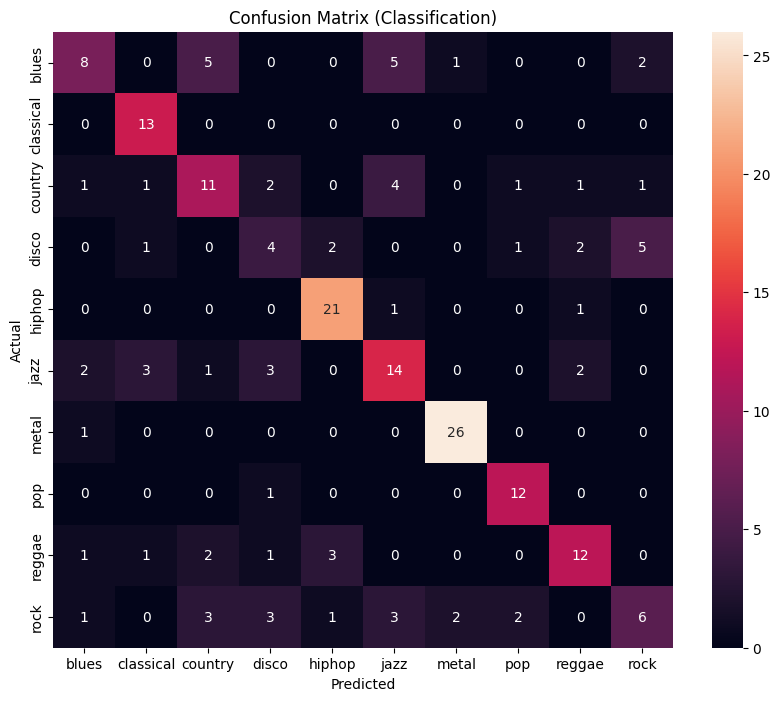

In [ ]:
# Step 12: Evaluate Classification Model
test_loss_clf, test_acc_clf = model_classification.evaluate(X_test, y_test_clf)
print(f"Classification Test Accuracy: {test_acc_clf:.2f}")

# Confusion Matrix
y_pred_clf = model_classification.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test_clf, y_pred_clf)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix (Classification)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Step 13: Build and Train Multi-Variable Regression Model
model_regression = Ridge(alpha=1.0)

# Ensure y_train_reg contains only numeric columns
y_train_reg_numeric = y_train_reg.select_dtypes(include=np.number)
y_test_reg_numeric = y_test_reg.select_dtypes(include=np.number)

if y_train_reg_numeric.empty or y_test_reg_numeric.empty:
    raise ValueError("No numeric columns found in the regression targets. Check your data preprocessing.")

# Train the regression model
model_regression.fit(X_train, y_train_reg_numeric)

Ridge()

In [ ]:
# Step 14: Evaluate Regression Model
y_pred_reg = model_regression.predict(X_test)
mse = mean_squared_error(y_test_reg_numeric, y_pred_reg)
r2 = r2_score(y_test_reg_numeric, y_pred_reg)
print(f"Regression Mean Squared Error: {mse:.2f}")
print(f"Regression R-squared: {r2:.2f}")

# Residual Analysis
residuals = y_test_reg_numeric - y_pred_reg

# Check if residuals have zero variance
if np.isclose(residuals.var(axis=0), 0).all():
    print("Residuals have zero variance. KDE calculation is skipped.")
else:
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title("Residual Distribution")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.show()

Regression Mean Squared Error: 0.00
Regression R-squared: 1.00
Residuals have zero variance. KDE calculation is skipped.


In [ ]:
# Step 15: Real-Life Implications and Business Risk Analysis
print("\n--- Real-Life Implications ---")
print("1. Genre Classification: Can be used in music streaming services to recommend songs or create playlists.")
print("2. Tempo Prediction: Useful for DJ software to match beats or for fitness apps to recommend workout music.")
print("\n--- Business Risks ---")
print("1. Misclassification: Incorrect genre labels could lead to poor user experience.")
print("2. Inaccurate Tempo Prediction: Could affect the usability of DJ or fitness apps.")
print("3. Overfitting: The model may perform poorly on new, unseen data.")
print("4. Data Bias: The dataset may not represent all music genres equally, leading to biased predictions.")


--- Real-Life Implications ---
1. Genre Classification: Can be used in music streaming services to recommend songs or create playlists.
2. Tempo Prediction: Useful for DJ software to match beats or for fitness apps to recommend workout music.

--- Business Risks ---
1. Misclassification: Incorrect genre labels could lead to poor user experience.
2. Inaccurate Tempo Prediction: Could affect the usability of DJ or fitness apps.
3. Overfitting: The model may perform poorly on new, unseen data.
4. Data Bias: The dataset may not represent all music genres equally, leading to biased predictions.


In [ ]:
# Save Models and Encoder
joblib.dump(model_regression, 'regression_model.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')
model_classification.save('classification_model.h5')

print("\n--- Final Summary ---")
print(f"Classification Test Accuracy: {test_acc_clf:.2f}")
print(f"Regression Mean Squared Error: {mse:.2f}")
print(f"Regression R-squared: {r2:.2f}")


--- Final Summary ---
Classification Test Accuracy: 0.63
Regression Mean Squared Error: 0.00
Regression R-squared: 1.00
